Exploring the data

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import os
import sys
import importlib
import functions.functions as aux_fun
importlib.reload(aux_fun)
from datetime import datetime as dti

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay,confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline


pd.options.mode.chained_assignment = None 

Reading data

In [2]:
# Read data

# Portifolio and profile datasets
portfolio = pd.read_csv('portfolio.csv')
profile = pd.read_csv('profile_clustered.csv')

# User and offer data, already treated in Data Preparation 
# user_offer_df = pd.read_csv('user_offer.csv').astype({'offer_id_rec':np.int8})
user_offer_df = pd.read_csv('user_offer2.csv').astype({'offer_id_rec':np.int8})

Quick look at the data

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id,offer_id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,2
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,3
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,4
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,5
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,6
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,7
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,8
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,9


In [4]:
profile.head()

,gender,age,id,became_member_on,income,user_id,rela_member_years,user_cluster
0,NI,55.0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,0,1.45,0
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,1.03,2
2,NI,55.0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,64000.0,2,0.04,0
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,3,1.21,2
4,NI,55.0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,64000.0,4,0.98,0


In [5]:
user_offer_df.head()

,offer_id_rec,user_id,valid_view_rate,completed_after_view_rate,tra_offer_infl,offer_type,gender,age,income,rela_member_years,user_cluster,age_quartile,income_quartile,member_years_quartile
0,7,3,1.0,0.0,49.39,informational,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"
1,3,3,1.0,1.0,19.89,bogo,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"
2,0,3,1.0,1.0,21.72,bogo,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"
3,8,3,1.0,0.0,0.00,bogo,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"
4,7,4,0.0,0.0,0.00,informational,NI,55.0,64000.0,0.98,0,"(45.0, 55.0]","(51000.0, 64000.0]","(0.57, 0.98]"


#### Preparing dataset

Alguns usuários receberam a mesma oferta durante o experimento. Eles podem ter completado uma parte dessas ofertas recebidas, o que gera valores de completed_after_view_rate quebrados, como 0.6, 0.25.  

Para a modelagem, será considerado duas classes para a taxa de completada. Se o usuário chegou a completa alguma das ofertas recebidas, então receberá 1. Se não, 0. 

In [6]:
user_offer_df.loc[user_offer_df.completed_after_view_rate > 0, 'completed_after_view_rate'] = 1 

user_offer_df['completed_after_view_rate'].value_counts()
# Classes balanceadas

0.0    42247
1.0    21041
Name: completed_after_view_rate, dtype: int64

In [7]:
# Duas abordagem.
# Uma para a taxa de completas
# Outra para transação
# Separar os datasets para cada assunto

# 'offer_id_rec' - use to indtify the offer id
# 'user_id' - use to indtify the user id, not use in modeling
# 'valid_view_rate' - not use, since is built-in na taxa de completos
# 'completed_after_view_rate' - main variable
# 'tra_offer_infl' - not use for the first attempt
# 'offer_type' - dummy varible
# 'gender' - dummy varible
# 'age' - continuos variable, use
# 'income' - continuos variable, use
# 'rela_member_years' - - continuos variable, use
# 'user_cluster' - dummy variable
# 'age_quartile' - not use quartile groups in modeling
# 'income_quartile' - not use quartile groups in modeling
# 'member_years_quartile' - not use quartile groups in modeling


complete_df = user_offer_df[['offer_id_rec', 'completed_after_view_rate', 
    'offer_type', 'gender', 'age', 'income', 'rela_member_years', 'user_cluster']]

# Para completar, informational não tem completar
complete_df = complete_df.loc[complete_df['offer_type']!='informational']


# Dummy variable
complete_df = pd.get_dummies(data=complete_df, columns=['offer_id_rec', 'offer_type', 'gender', 'user_cluster'])

# Columns. Total = 25 (1 target)
# ['completed_after_view_rate', 'age', 'income', 'rela_member_years',
#        'offer_id_rec_0', 'offer_id_rec_1', 'offer_id_rec_2', 'offer_id_rec_3',
#        'offer_id_rec_4', 'offer_id_rec_5', 'offer_id_rec_6', 'offer_id_rec_7',
#        'offer_id_rec_8', 'offer_id_rec_9', 'offer_type_bogo',
#        'offer_type_discount', 'offer_type_informational', 'gender_F',
#        'gender_M', 'gender_NI', 'gender_O', 'user_cluster_0', 'user_cluster_1',
#        'user_cluster_2', 'user_cluster_3']


In [8]:
# For continuos variable, like income and age can disturb the classification.
# The Scaler is used here again.

# Standarlize continuous variable
scaler = StandardScaler()
scaler.fit(profile[['age', 'income', 'rela_member_years']])
complete_df.loc[:, ['age', 'income', 'rela_member_years']] =\
    scaler.transform(complete_df[['age', 'income', 'rela_member_years']])

complete_df.head()

,completed_after_view_rate,age,income,rela_member_years,offer_id_rec_0,offer_id_rec_1,offer_id_rec_3,offer_id_rec_4,offer_id_rec_5,offer_id_rec_6,...,offer_type_bogo,offer_type_discount,gender_F,gender_M,gender_NI,gender_O,user_cluster_0,user_cluster_1,user_cluster_2,user_cluster_3
1,1.0,1.264535,1.723728,-0.184330,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,1,0
2,1.0,1.264535,1.723728,-0.184330,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
3,0.0,1.264535,1.723728,-0.184330,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
5,0.0,0.032578,-0.060733,-0.388480,0,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0
8,0.0,0.402165,-0.407712,-0.486116,1,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0


In [9]:
scaler.mean_

array([5.44711176e+01, 6.52252353e+04, 1.41767118e+00])

#### Modeling data

##### Complete Rate Classification

Perfomance with Train

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     20776
         1.0       0.99      0.99      0.99     14669

    accuracy                           0.99     35445
   macro avg       0.99      0.99      0.99     35445
weighted avg       0.99      0.99      0.99     35445



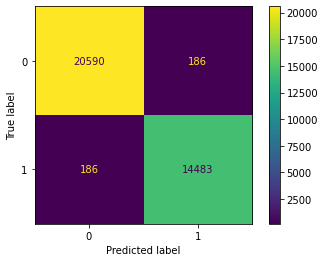

Perfomance with Test

              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69      8820
         1.0       0.57      0.58      0.58      6372

    accuracy                           0.64     15192
   macro avg       0.63      0.63      0.63     15192
weighted avg       0.64      0.64      0.64     15192



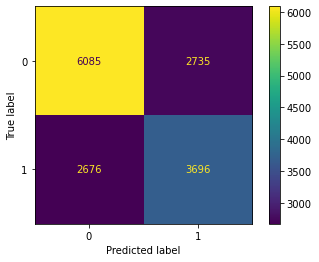

In [10]:
# Target features and others

y = complete_df['completed_after_view_rate'] # target
X = complete_df.drop(columns='completed_after_view_rate') # features

# Train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)#, random_state=10)

# Initiate model
model_class = DecisionTreeClassifier(class_weight='balanced')

# Train model
model_class.fit(X_train, y_train)

aux_fun.evaluate_model(model_class, X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test)

Overfitting com dados de treinamento.

Baseado no recall, tentar otimizar essa métrica modificando a profundidada da árvore

O modelo acima foi criado separando os dois processos, tanto de transformação quanto de treino de modelo.  

O próximo é feito com pipeline

In [11]:
complete_df2 = user_offer_df[['offer_id_rec', 'completed_after_view_rate', 
    'offer_type', 'gender', 'age', 'income', 'rela_member_years', 'user_cluster']]

# Para completar, informational não tem completar
complete_df2 = complete_df2.loc[complete_df2['offer_type']!='informational']

complete_df2

y = complete_df2['completed_after_view_rate'] # target
X = complete_df2.drop(columns='completed_after_view_rate')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)#, random_state=1

In [12]:
X.head()

,offer_id_rec,offer_type,gender,age,income,rela_member_years,user_cluster
1,3,bogo,F,75.0,100000.0,1.21,2
2,0,bogo,F,75.0,100000.0,1.21,2
3,8,bogo,F,75.0,100000.0,1.21,2
5,4,discount,NI,55.0,64000.0,0.98,0
8,0,bogo,F,61.0,57000.0,0.87,0


In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50637 entries, 1 to 63287
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   offer_id_rec       50637 non-null  int8   
 1   offer_type         50637 non-null  object 
 2   gender             50637 non-null  object 
 3   age                50637 non-null  float64
 4   income             50637 non-null  float64
 5   rela_member_years  50637 non-null  float64
 6   user_cluster       50637 non-null  int64  
dtypes: float64(3), int64(1), int8(1), object(2)
memory usage: 2.8+ MB


In [38]:
# Pipeline

sca     = StandardScaler()
encoder = OneHotEncoder(sparse=False, dtype='int')
clf     = DecisionTreeClassifier(class_weight='balanced')

transformers = make_column_transformer( 
    (sca, make_column_selector(dtype_include=np.float64)),
    (encoder, make_column_selector(dtype_exclude=np.float64))
)

pipeline = Pipeline(
    [
        ('tranformer', transformers),
        ('classifier', clf)
    ]
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('tranformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019D5075FEE0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(dtype='int',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019D5075F160>)])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced'))])

In [33]:

transformers.fit(X_train)
colunas = transformers.get_feature_names_out()
a = transformers.transform(X_train)
b = transformers.transform(X_test[:1])


pd.DataFrame(a, columns=colunas)

,standardscaler__age,standardscaler__income,standardscaler__rela_member_years,onehotencoder__offer_id_rec_0,onehotencoder__offer_id_rec_1,onehotencoder__offer_id_rec_3,onehotencoder__offer_id_rec_4,onehotencoder__offer_id_rec_5,onehotencoder__offer_id_rec_6,onehotencoder__offer_id_rec_8,...,onehotencoder__offer_type_bogo,onehotencoder__offer_type_discount,onehotencoder__gender_F,onehotencoder__gender_M,onehotencoder__gender_NI,onehotencoder__gender_O,onehotencoder__user_cluster_0,onehotencoder__user_cluster_1,onehotencoder__user_cluster_2,onehotencoder__user_cluster_3
0,-0.699494,-1.591410,-0.863513,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.206503,0.381386,0.803839,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.083255,0.233427,-1.040891,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.945990,-0.605012,1.291628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.348112,1.466424,-0.570840,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35440,1.149223,0.233427,1.637515,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
35441,0.532984,1.515744,-0.810300,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
35442,-1.562229,-0.900931,-1.156187,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
35443,-0.576247,1.121185,-0.801431,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [109]:
import sklearn
sklearn.__version__

importlib.reload(sklearn.compose)

<module 'sklearn.compose' from 'C:\\Users\\ismae\\AppData\\Local\\Programs\\Python\\Python38\\lib\\site-packages\\sklearn\\compose\\__init__.py'>

Perfomance with Train

              precision    recall  f1-score   support

         0.0       0.79      0.71      0.75     20760
         1.0       0.64      0.73      0.69     14685

    accuracy                           0.72     35445
   macro avg       0.72      0.72      0.72     35445
weighted avg       0.73      0.72      0.72     35445



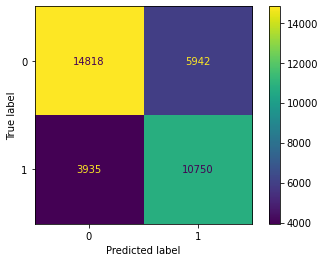

Perfomance with Test

              precision    recall  f1-score   support

         0.0       0.77      0.70      0.73      8836
         1.0       0.63      0.70      0.66      6356

    accuracy                           0.70     15192
   macro avg       0.70      0.70      0.70     15192
weighted avg       0.71      0.70      0.70     15192



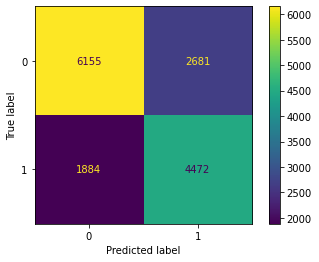

In [13]:
# Usar gridsearch para procurar a melhor profundidade da árvore
params_grid = {'max_depth':range(5,40), 'criterion': ['gini', 'entropy']}

# Model
model_class = DecisionTreeClassifier(class_weight='balanced')
# GridSearch
clf = GridSearchCV(model_class, params_grid, scoring='recall_micro')

# Fit
clf.fit(X_train, y_train)
# Best result
model = clf.best_estimator_

aux_fun.evaluate_model(model, X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test)

Melhor modelo é com 10 de profundidade

Recall é a melhor métrica para avaliar, pois compara os valores ao que é visto na realidade.

Avaliando as imporâncias das variáveis na previsão

In [14]:
# Olhando a importancia de cada variável na classificação
def create_df_feature_importances(X, model):
    '''
    TODO
    '''
    df_feature = pd.DataFrame()
    df_feature['Variable'] = X.columns
    df_feature['Importance'] = model.feature_importances_
    return df_feature

create_df_feature_importances(X, model).sort_values('Importance', ascending=False)

,Variable,Importance
2,rela_member_years,0.280847
15,gender_NI,0.180789
6,offer_id_rec_4,0.114222
1,income,0.110701
8,offer_id_rec_6,0.079134
7,offer_id_rec_5,0.078074
0,age,0.044852
9,offer_id_rec_8,0.043962
14,gender_M,0.027062
11,offer_type_bogo,0.009022


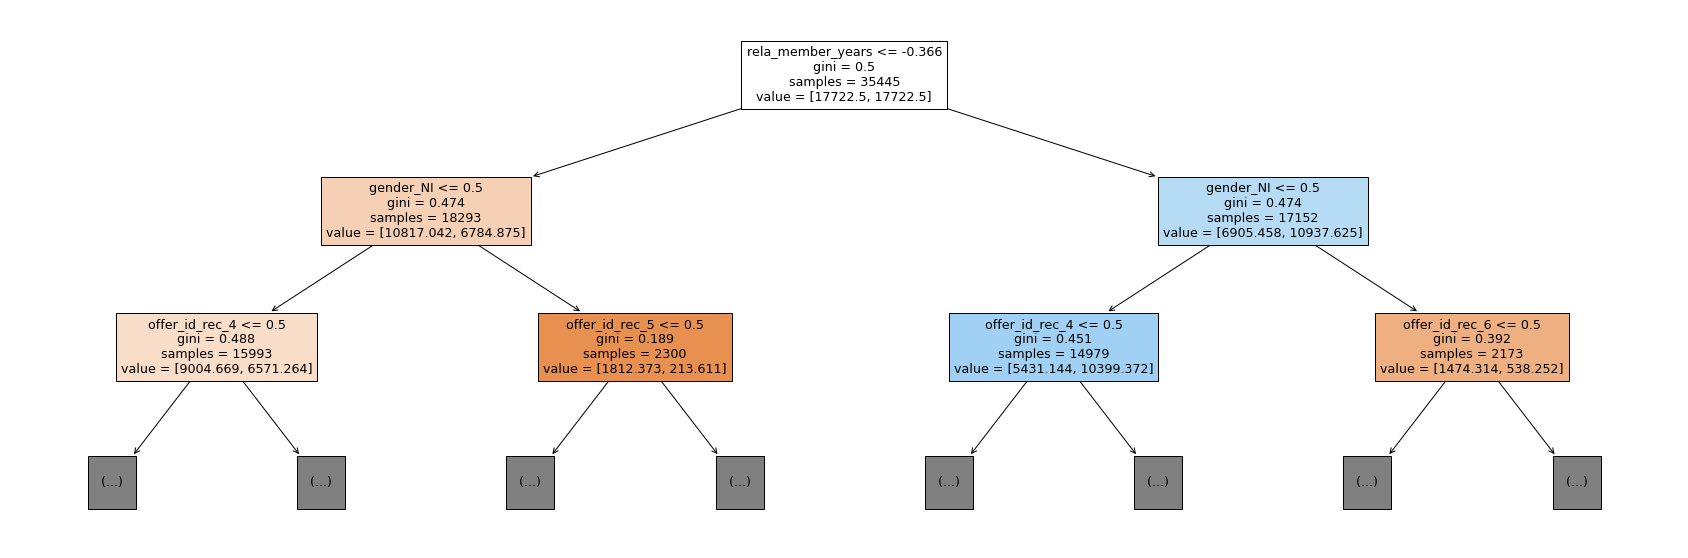

In [15]:
# Visualizando a árvore

plt.figure(figsize=(30,10))
plot_tree(model, max_depth=2, feature_names=X.columns, filled=True)
plt.show()

A falta de informações (gender == NI) impacta no modelo, sendo um ponto de divisão para os dados.

Como usar esse modelo

In [45]:
# Usar o modelo para enviar ofertas para usuários

# O modelo criado pode ser utilizado para selecionar quais ofertas seriam completadas
# a partir do perfil do usuário.
importlib.reload(aux_fun)

def best_user_offer_to_send(user, scaler, model, X_train):
    # Filter user in profile
    user_df = profile.loc[profile['user_id']==user]
    # Select columns
    user_df = user_df[['gender', 'age', 'income', 'rela_member_years', 'user_cluster']]
    
    # Criar uma simulação de entregar todas as ofertas para o usuário
    offers_df = portfolio[['offer_id', 'offer_type']]
    offers_df.columns = ['offer_id_rec', 'offer_type']
    offers_df_ori = aux_fun.expand_dataframe(user_df, offers_df)

    # Dummy variables
    offers_df = pd.get_dummies(data=offers_df_ori, columns=['offer_id_rec', 
        'offer_type', 'gender', 'user_cluster'])
    # Add other columns
    other_cols = np.setdiff1d(X_train.columns, offers_df.columns)    
    for c in other_cols:
         offers_df[c] = 0
    # Sequence of columns
    offers_df = offers_df[X_train.columns]

    # Scaler Age, income and time as member
    continuos = offers_df[['age', 'income', 'rela_member_years']]
    offers_df.loc[:, ['age', 'income', 'rela_member_years']] = scaler.transform(continuos)

    # Predict
    offers_df_ori['complete_pred'] = model.predict(offers_df)

    # Filter
    best_offers = offers_df_ori.loc[offers_df_ori['complete_pred'] == 1]

    # Create list
    recs = []
    for idx, row in best_offers.iterrows():
        recs.append( 'Offer ' + str(row['offer_id_rec']) +\
            ' - ' + str(row['offer_type']))

    print(recs)
    
    return recs#best_offers

for user in range(10,1900):
    best_user_offer_to_send(user, scaler, model, X_train)

['Offer 8 - bogo']
['Offer 5 - discount', 'Offer 6 - discount']
['Offer 4 - discount', 'Offer 5 - discount', 'Offer 6 - discount']
['Offer 0 - bogo', 'Offer 1 - bogo', 'Offer 2 - informational', 'Offer 5 - discount', 'Offer 6 - discount', 'Offer 7 - informational', 'Offer 8 - bogo', 'Offer 9 - discount']
['Offer 5 - discount', 'Offer 6 - discount']
['Offer 0 - bogo', 'Offer 1 - bogo', 'Offer 2 - informational', 'Offer 3 - bogo', 'Offer 5 - discount', 'Offer 6 - discount', 'Offer 7 - informational', 'Offer 8 - bogo', 'Offer 9 - discount']
['Offer 0 - bogo', 'Offer 1 - bogo', 'Offer 2 - informational', 'Offer 3 - bogo', 'Offer 4 - discount', 'Offer 5 - discount', 'Offer 6 - discount', 'Offer 7 - informational', 'Offer 8 - bogo', 'Offer 9 - discount']
[]
['Offer 5 - discount', 'Offer 6 - discount']
['Offer 5 - discount', 'Offer 6 - discount', 'Offer 8 - bogo']
['Offer 0 - bogo', 'Offer 1 - bogo', 'Offer 2 - informational', 'Offer 3 - bogo', 'Offer 5 - discount', 'Offer 6 - discount', 'Off